In [1]:
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
from math import sqrt, exp, log
import seaborn as sbn

In [2]:
def proposal(y, u):
    """Returns the proposal, i.e. a draw from Q(x,y) = N(x|y,uI)."""
    return stats.multivariate_normal.rvs(mean=y, cov=u*np.eye(len(y)))

In [3]:
def propLogDensity(x, muprior, sig2prior, scores):
    """Calculate the log of the proportional density funciton f."""
    if x[1] <= 0:
        return -np.inf
    logprob = muprior.logpdf(x[0]) + sig2prior.logpdf(x[1])
    logprob += stats.norm.logpdf(scores, loc=x[0], scale=np.sqrt(x[1])).sum()
    return logprob

In [4]:
def acceptance(x, y, muprior, sig2prior, scores):
    """
    Returns the acceptance probability of moving from y to x.
    """
    return np.exp(min(0, 
                  propLogDensity(x, muprior, sig2prior, scores) 
                - propLogDensity(y, muprior, sig2prior, scores)
    ))

In [5]:
def metropolis(y0, u, n_samples, muprior, sig2prior, scores):
    """
    Use the Metropolis algorithm to sample from posterior.
    Parameters:
        x0 ((2,) ndarray): The first entry is mu, the second entry is sigma^2.
        u (float): The standard deviation parameter for the proposal function.
        n_samples (int): The number of samples to generate.
        muprior, sig2prior (scipy.stats distributions): The prior distributions for mu and sigma^2.
        scores ((N,) ndarray): The array of exam scores
    
    Returns:
        draws ((n_samples, 2) ndarray): The MCMC samples.
        logprobs ((n_samples,) ndarray): The values of log f(y) of the samples.
        accept_rate (float): The proportion of accepted proposed samples.
    """
    Qs = [] 
    log_probs =[]
    #following algorithm 1
    iter = 0
    for t in range(n_samples):
        x = proposal(y0, u)
        a = np.random.uniform(0,1)
        if a <= acceptance(x, y0, muprior, sig2prior, scores):
            y1 = x
            iter+=1
        else:
            y1 = y0
        #reset for next loop
        y0 = y1
        Qs.append(y1)
        log_probs.append(propLogDensity(y0, muprior, sig2prior, scores))

    #return expected stuff
    accept_rate = iter/n_samples
    Qs = np.array(Qs)
    return Qs, log_probs, accept_rate


In [6]:
# Load in the data and initialize priors
scores = np.load("examscores.npy")

# Prior sigma^2 ~ IG(alpha, beta)
alpha = 3
beta = 50
sig2prior = stats.invgamma(alpha, scale=beta)

# Prior mu ~ N(m, s)
m = 80
s = 4
muprior = stats.norm(loc=m, scale=sqrt(s**2))

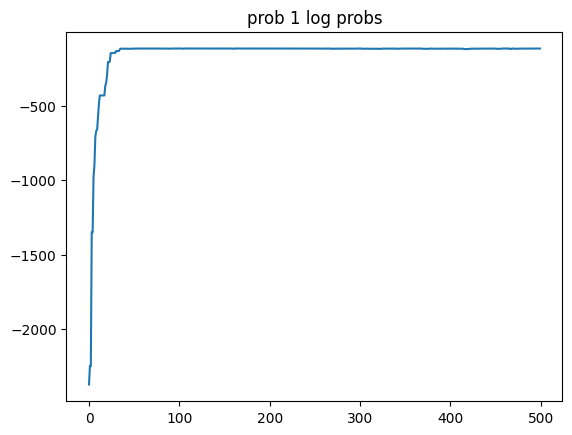

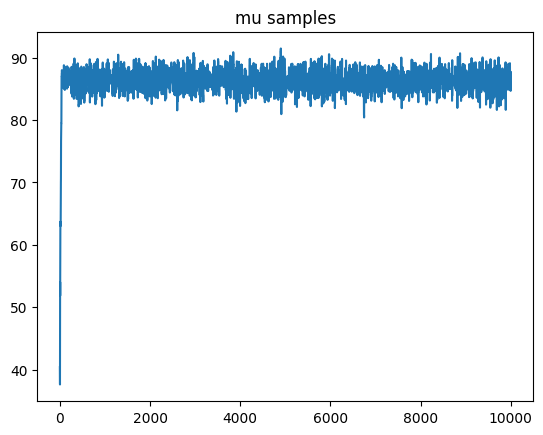

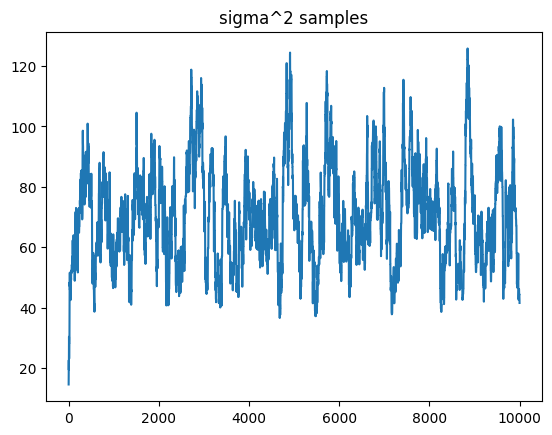

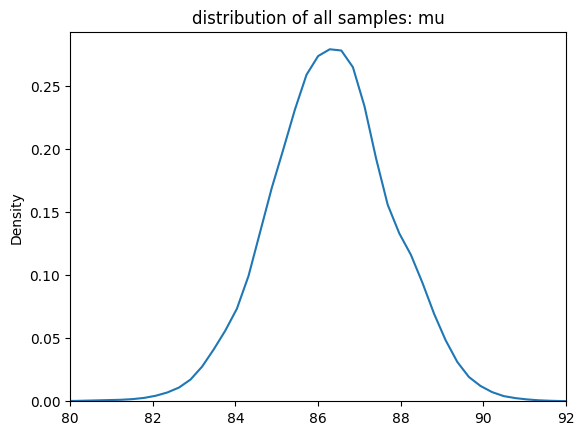

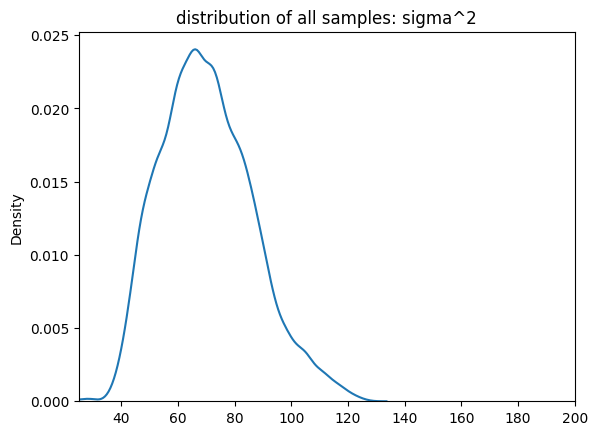

In [7]:
y0 = np.array([40,10])
Qs, log_probs, acc_rate = metropolis(y0, 20, 10000, muprior, sig2prior, scores)
#plot log prob of first 500 samples
plt.plot(log_probs[:500])
plt.title("prob 1 log probs")
plt.show()

#plot samples for mu in the order drawn 
plt.plot(Qs[:,0])
plt.title("mu samples")
plt.show()

#plot sigma^2 samples in order drawn
plt.plot(Qs[:,1])
plt.title("sigma^2 samples")
plt.show()

#plot distribution of all samples for mu and sigma^2
sbn.kdeplot(Qs[:,0])
plt.xlim(80,92)
plt.title("distribution of all samples: mu")
plt.show()

sbn.kdeplot(Qs[:,1])
plt.xlim(25,200)
plt.title("distribution of all samples: sigma^2")
plt.show()


## Ising Model

In [8]:
def random_lattice(n):
    """Construct a random spin configuration for an nxn lattice."""
    random_spin = np.zeros((n,n))
    for k in range(n):
        random_spin[k,:] = 2*np.random.binomial(1,.5, n) -1
    return random_spin

In [9]:
def lattice_energy(L):
    """Computer the energy of the spin configuration corresponding to the
    lattice L.
    Parameter:
     L (ndarray): A lattice that we want the spin configuration for.
    
    Returns:
     (float): The spinfiguration of the lattice.
    """
    #compute H(sigma)
    J=1
    H = -J * (np.sum(L*np.roll(L, 1, 1)) + np.sum(L*np.roll(L, 1, 0)))

    return H

In [10]:
def flip_location(n):
    """Choose a random pair of indices 0 <= i,j <= n-1.
    Parameter:
     n (int): 1/(n^2) probability for each location
     
    Returns:
     (index1, index2) (tuple): the tuple pair of the chosen indices. 
    """
    #indices i and j
    i = np.random.uniform(0, n-1)
    j = np.random.uniform(0, n-1)
    return int(i)+1, int(j)+1

In [11]:
def updated_energy(L, L_energy, i, j):
    """Compute the energy of the spin configuration that results
    when the (i,j)th spin of L is flipped.
    
    Parameters:
     L (ndarray): the spin configuration 
     L_energy (float): the energy of the spin configuration.
     i (int): the first index.
     j (int): the second index.
    Returns:
     (float): the energy of the new updated lattice
    """
    #construct the second term in 19.2
    # it's all the adjacent stuff to i,j
    up = np.roll(L, 1, 1)[i,j]
    right = np.roll(L, 1, 0)[i,j]
    left = np.roll(L, -1, 1)[i,j]
    down = np.roll(L, -1, 0)[i,j]

    second_term = 2 * (up+down+right+left)*L[i,j]

    H_sigma_star = L_energy + second_term
    #19.2
    return H_sigma_star

In [14]:
def accept(beta, energy_old, energy_new):
    """Accept or reject the new spin configuration.
    
    Parameters:
     beta (float): a quantity inversly proportional to the temperature.
     energy_old (float): the energy of the old lattice.
     energy_new (float): the energy of the updated lattice.
     
    Returns:
     (boolean): whether the new energy should be accepted or not
    """
    #eq 19.1
    if energy_new < energy_old:
        A = 1
        
    else:
        A = np.exp(beta*(energy_old-energy_new))

    #use the hint for returning
    return np.random.binomial(1,A) == 1

In [27]:
def ising_metropolis(beta, n=100, n_samples=5000, burn_in=195000):
    """Use the Metropolis algorithm to choose new spin configurations.

    Parameters:
        beta (float > 0): Constant inversely proportional to the temperature.
        N (int > 0): The size of the lattice.
        n_samples (int): The number of samples to generate.
        burnin (int): The number of iterations to burn before sampling.

    Returns:
        ((n_samples//100, n,n) ndarray): The sampled spin configurations.
        (n_samples) ndarray: The weighted energies of each configuration.
        (float): The proportion of proposed samples that were accepted.
    """
    # Initialize an nxn lattice for a spin configuration
    lattice = random_lattice(n)
    energy_history = []
    samples = []
    lattice_energy_val = lattice_energy(lattice)
    acceptance_count = 0

    for iter in range(n_samples + burn_in):
        flip_location_site = flip_location(n)

        i, j = flip_location_site[0], flip_location_site[1]
        new_energy = updated_energy(lattice, lattice_energy_val, i, j)
        sigma_star = np.copy(lattice) 
        sigma_star[i, j] *= -1

        # Determine whether to accept/reject
        accept_flag = accept(beta, lattice_energy_val, new_energy)
        if accept_flag:
            lattice = np.copy(sigma_star)
            lattice_energy_val = new_energy

        #recording every 100th sample (to prevent memory failure)
        if (iter % 100) and iter > burn_in:  
            samples.append(np.copy(lattice))
            if accept_flag:
                acceptance_count += 1

        #4.  Keep track of -beta H(sigma)
        energy_history.append(-beta * lattice_energy_val)

    # plotting
    fig = plt.figure(figsize=(10, 6))
    axs1 = plt.subplot(121)
    axs2 = plt.subplot(122)

    #log probs
    axs1.plot(energy_history)
    axs1.set_title(f"log probs, beta = {beta}")

    #late sample 
    axs2.imshow(samples[-1], cmap='gray')
    axs2.set_title(f"late sample, beta = {beta}")

    plt.tight_layout()
    plt.show()

    return samples, energy_history, acceptance_count / n_samples

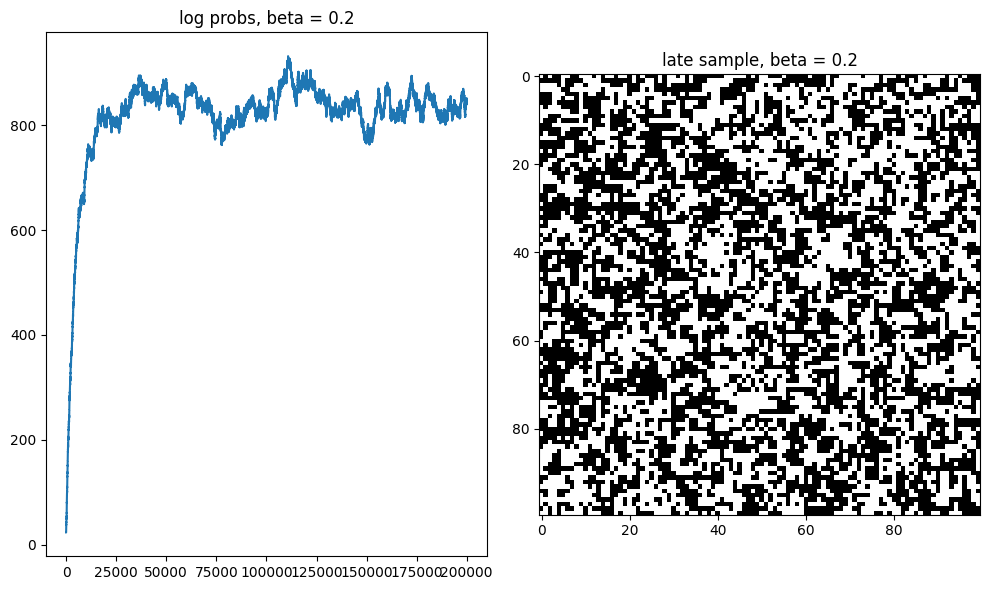

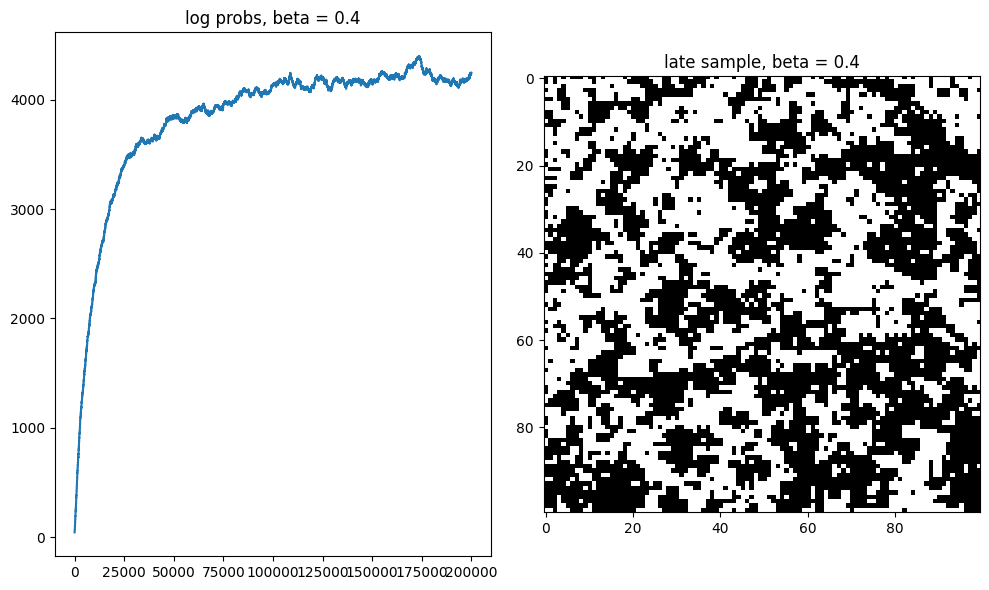

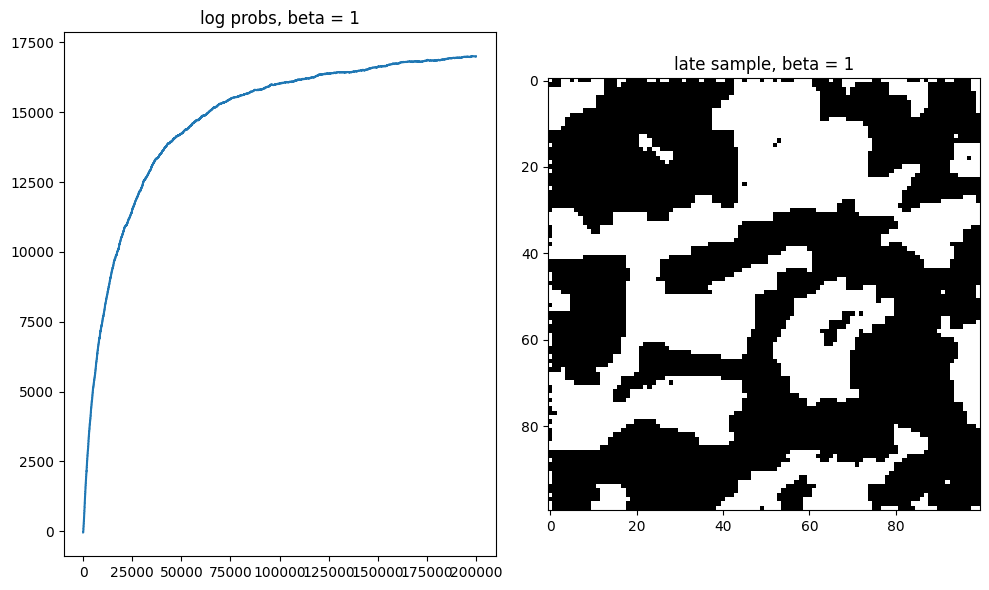

In [28]:
#Test your sampler on a 100 × 100 grid with 200000 total iterations, 
#with n_samples large enough so that you will keep 50 samples, 
#for β = 0.2, 0.4, 1.

for beta in [0.2, 0.4, 1]:
    #plotting
    ising_metropolis(beta=beta)